# Zoom Experiments

In [93]:
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import Resize
from PIL import Image
import torch
import torch.nn as nn
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


## Load pre-trained models

In [94]:
vgg_model = models.vgg19(weights=True)
resnet_model = models.resnet50(pretrained=True)
densenet_model = models.densenet121(pretrained=True)

In [95]:
img = "../RP1_Mamba_Unet/dataset/OpenEarthMap/OpenEarthMap_wo_xBD/aachen/images/aachen_4.tif"
patch_size = 200


img = Image.open(img)

In [96]:
img = transforms.ToTensor()(img)
if img.shape[1] != 1000:
    resizer = transforms.Compose([transforms.Resize((1000, 1000))])
    img = resizer(img)
img = img.unsqueeze_(dim=0)
zoom_matrix_dim = int(img.shape[2] / patch_size)
print(img.shape, zoom_matrix_dim)

torch.Size([1, 3, 1000, 1000]) 5


In [97]:
def vgg_feature_extractor(img,zoom_matrix_dim):
    num_features = vgg_model.classifier[0].in_features
    new_classifier = nn.Sequential(
        nn.Linear(num_features, 4096),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(4096, zoom_matrix_dim*zoom_matrix_dim)  # output size customization
    )
    # replace the classifier layer
    vgg_model.classifier = new_classifier
    # model evaluation mode
    vgg_model.eval()
    # get the feature embedding
    vgg_feature_embdding = vgg_model(img).view(1,zoom_matrix_dim,zoom_matrix_dim).permute(1,2,0).detach().numpy()
    return vgg_feature_embdding
def resnet_feature_extractor(img,zoom_matrix_dim):
    num_features = resnet_model.fc.in_features
    new_classifier = nn.Sequential(
        nn.Linear(num_features, 4096),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(4096, zoom_matrix_dim*zoom_matrix_dim)  # output size customization
    )
    # replace the classifier layer
    resnet_model.fc = new_classifier
    # model evaluation mode
    resnet_model.eval()
    # get the feature embedding
    resnet_feature_embdding = resnet_model(img).view(1,zoom_matrix_dim,zoom_matrix_dim).permute(1,2,0).detach().numpy()
    return resnet_feature_embdding
def densenet_feature_extractor(img,zoom_matrix_dim):
    num_features = densenet_model.classifier.in_features
    new_classifier = nn.Sequential(
        nn.Linear(num_features, 4096),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(4096, zoom_matrix_dim*zoom_matrix_dim)  # output size customization
    )
    # replace the classifier layer
    densenet_model.classifier = new_classifier
    # model evaluation mode
    densenet_model.eval()
    # get the feature embedding
    densenet_feature_embdding = densenet_model(img).view(1,zoom_matrix_dim,zoom_matrix_dim).permute(1,2,0).detach().numpy()
    return densenet_feature_embdding

In [98]:
def embedding_normalization(feature):
    # 1. Trim out outliers
    # compute the mean and standard deviation
    mean = np.mean(feature)
    std = np.std(feature)

    # trim out outliers
    threshold = 3
    lower_bound = mean - threshold * std
    upper_bound = mean + threshold * std

    # replace the outliers with boundary values
    clipped_matrix = np.clip(feature, lower_bound, upper_bound)

    # find the max and min values
    min_value = np.min(clipped_matrix)
    max_value = np.max(clipped_matrix)

    # scaled
    normalized_matrix = ((clipped_matrix - min_value) / (max_value - min_value)) * (10 - 1) + 1
    return normalized_matrix

In [99]:
vgg_embedding = embedding_normalization(vgg_feature_extractor(img,zoom_matrix_dim))
resnet_embedding = embedding_normalization(resnet_feature_extractor(img,zoom_matrix_dim))
densenet_embedding = embedding_normalization(densenet_feature_extractor(img,zoom_matrix_dim))
feature_embedding = np.round((vgg_embedding + resnet_embedding + densenet_embedding)/3)

## Multi-scale Patch Generation

In [100]:
def multi_scale_patch_generation(feature_embed,patch_size,img):
    # create a container
    img_container = [img]
    zoom_matrix = np.squeeze(feature_embed,axis=2)

    for row in range(0,img.shape[2],patch_size):
        for col in range(0,img.shape[3],patch_size):
            extracted_patch = _patch_extract(row_loc=row, col_loc=col, img=img, patch_size=patch_size)
            zoom_rate = zoom_matrix[int((row/patch_size)):int((row/patch_size))+1,
                        int((col/patch_size)):int((col/patch_size))+1][0][0]
            zoomed_patch = _patch_zoom(extracted_patch, int(zoom_rate), patch_size=patch_size)
            pad_patch = _patch_padding(zoomed_patch, img)
            img_container.append(pad_patch)

    img_container = torch.cat(img_container,dim=0)
    return img_container
def _patch_extract(row_loc, col_loc, img, patch_size):
    return img[:,:,row_loc:(row_loc+patch_size),col_loc:(col_loc+patch_size)] # patch cut
def _patch_zoom(extracted_patch, zoom_rate, patch_size):
    torch_resize = Resize([patch_size*zoom_rate,patch_size*zoom_rate]) # define resize class
    return torch_resize(extracted_patch)
def _patch_padding(zoomed_patch, img):
    padding_value = int((img.shape[2] - zoomed_patch.shape[2])/2)
    zero_padding = nn.ZeroPad2d(padding=(padding_value, padding_value, padding_value, padding_value))
    return zero_padding(zoomed_patch)

In [101]:
result = multi_scale_patch_generation(feature_embedding, patch_size, img)
result.shape

torch.Size([26, 3, 1000, 1000])

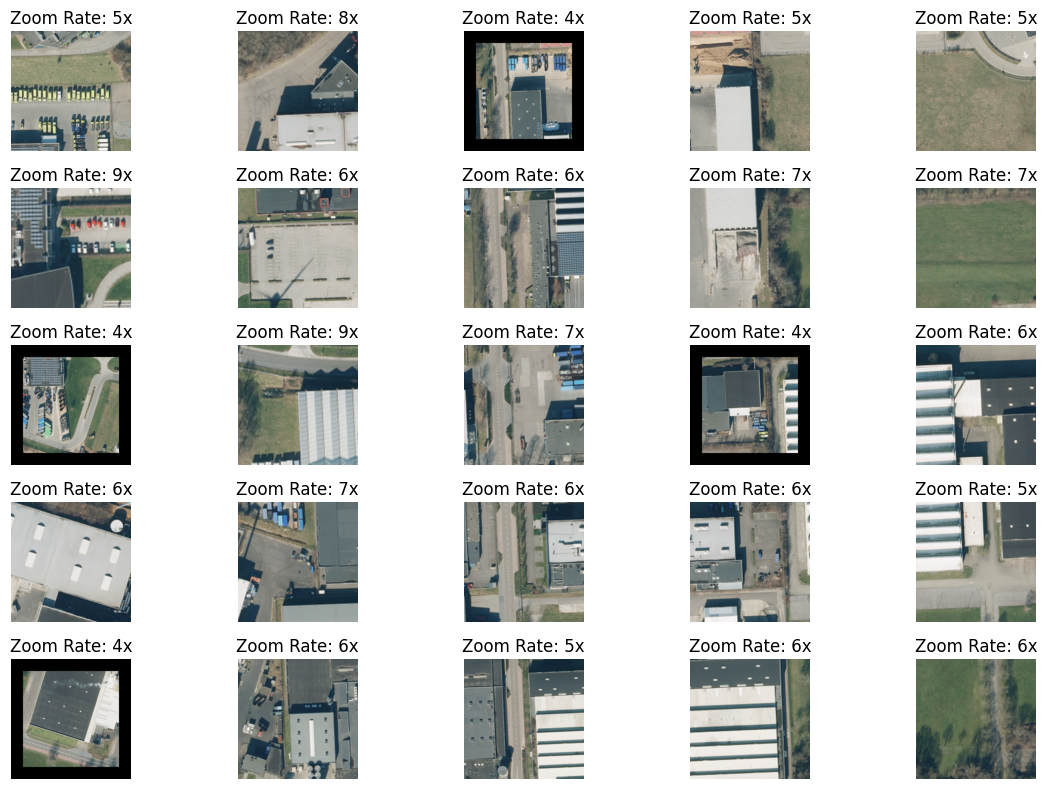

In [113]:
fig, ax = plt.subplots(5, 5, figsize=(12, 8))

count = 1
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(result[count].permute(1,2,0))
        count += 1
        ax[i,j].axis('off')
        ax[i,j].set_title("Zoom Rate: "+str(int(feature_embedding[i][j][0]))+"x")
            
plt.tight_layout()

(np.float64(-0.5), np.float64(999.5), np.float64(999.5), np.float64(-0.5))

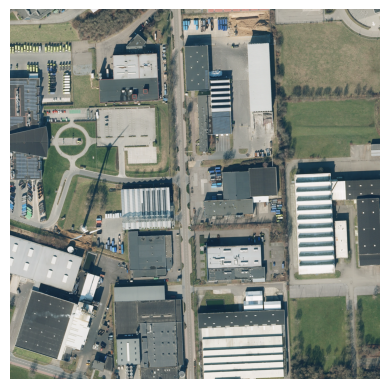

In [116]:
plt.imshow(result[0].permute(1,2,0))
plt.axis('off')